In [3]:
import sys
sys.path.append("../../../../../src")
sys.path.append("../")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.interpolate import interp1d

%matplotlib inline

plt.style.use(["science","bright","grid"])
folder  = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/two_tone_signal/"

In [4]:
# Voltages
N_voltages  = 1000000
N_samples   = 1008
N_processes = 36
time_step   = 1e-9
U_0         = 0.1
U_C         = 0.05
time_steps  = np.arange(N_voltages)*time_step
f0          = 40e3
f1          = 140e3
stat_size   = 10
cap         = 5e3
U_i         = U_0*np.sin(2*np.pi*f0*time_steps) + U_0*np.sin(2*np.pi*f1*time_steps)

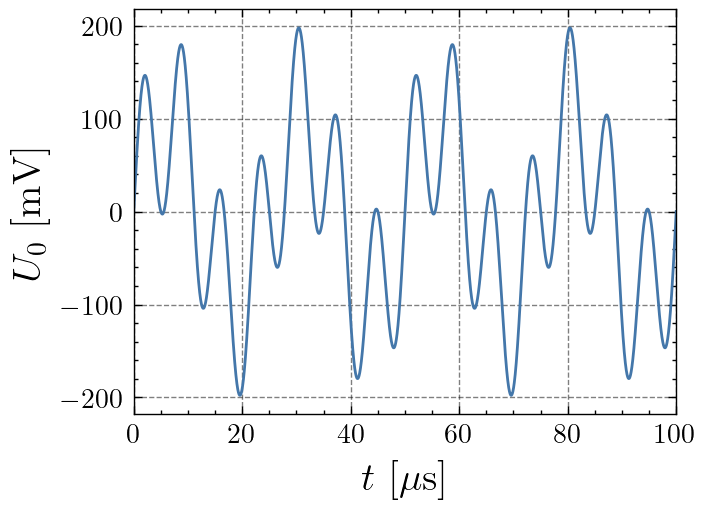

In [20]:
fig = plt.figure(dpi=200)
# fig.set_figheight(fig.get_figheight()*0.8)
ax  = fig.add_subplot()
ax.plot(time_steps*1e6, U_i*1000)
ax.set_xlabel("$t$ [$\mu$s]", size='x-large')
ax.set_ylabel("$U_0$ [mV]", size='x-large')
ax.set_xlim(0,100)
fig.savefig("../plots/frequency/two_tone_input.svg", transparent=True, bbox_inches='tight')

In [6]:
start   = 100000
dt      = 1e-9
f0      = 40e3
f1      = 140e3
f_vals  = [f1-3*f0, f1-2*f0, f1-f0, f1+f0, f1+2*f0, f1+3*f0, f1+4*f0, 2*f1+f0]
y_vals  = []
i_vals  = []
for i in range(1000):
    try:
        df  = pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{i}.csv")
        i_vals.append(i)
    except:
        print(f"{i} missing")
        continue
    arr     = df['Current'].values[start:]
    arr     = arr - np.mean(arr)
    xf, yf  = nanonets_utils.fft(arr, dt=1e-9, n_padded=5000000)
    func    = interp1d(xf, yf)
    yf0     = func(f0)
    yf1     = func(f1)
    y_in    = (yf0+yf1)/2
    y_out   = func(f_vals)/y_in
    y_vals.append(y_out)

1 missing
3 missing
5 missing
7 missing
8 missing
9 missing
10 missing
12 missing
13 missing
14 missing
15 missing
18 missing
19 missing
20 missing
23 missing
25 missing
26 missing
29 missing
30 missing
33 missing
35 missing
36 missing
37 missing
39 missing
42 missing
44 missing
46 missing
49 missing
50 missing
52 missing
53 missing
54 missing
58 missing
60 missing
63 missing
64 missing
65 missing
66 missing
67 missing
68 missing
70 missing
71 missing
72 missing
74 missing
77 missing
79 missing
80 missing
81 missing
82 missing
84 missing
86 missing
88 missing
92 missing
93 missing
97 missing
99 missing
100 missing
101 missing
102 missing
104 missing
105 missing
106 missing
107 missing
108 missing
109 missing
111 missing
113 missing
114 missing
115 missing
116 missing
117 missing
118 missing
120 missing
122 missing
126 missing
127 missing
128 missing
129 missing
131 missing
132 missing
137 missing
139 missing
141 missing
142 missing
145 missing
148 missing
149 missing
150 missing
152 mi

In [7]:
df_yvals    = pd.DataFrame(y_vals)
thd_vals    = np.sqrt((pd.DataFrame(y_vals)**2).sum(axis=1)).values
min_index   = i_vals[np.argmin(thd_vals)]
max_index   = i_vals[np.argmax(thd_vals)]
sort_index  = np.argsort(thd_vals)
df_min      = pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{min_index}.csv")
df_max      = pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{max_index}.csv")

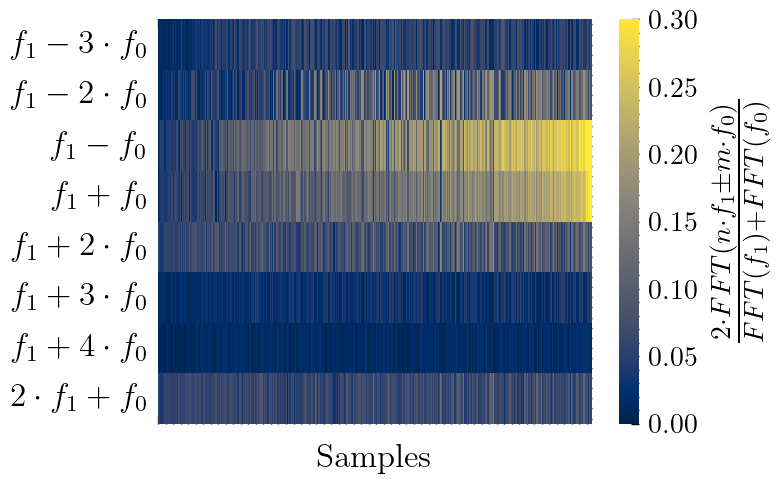

In [8]:
y_labels    = ["$f_1 - 3 \cdot f_0$",
               "$f_1 - 2 \cdot f_0$",
               "$f_1 - f_0$",
               "$f_1 + f_0$",
               "$f_1 + 2 \cdot f_0$",
               "$f_1 + 3 \cdot f_0$",
               "$f_1 + 4 \cdot f_0$",
               "$2 \cdot f_1 + f_0$"]
fig         = plt.figure(dpi=200)
ax          = fig.add_subplot()
ax          = sns.heatmap(df_yvals.iloc[sort_index,:].reset_index(drop=True).T, vmin=0, vmax=0.3, cmap='cividis', ax=ax)
ax.figure.axes[-1].set_ylabel('$\\frac{2 \cdot FFT(n \cdot f_1 \pm m \cdot f_0)}{FFT(f_1)+FFT(f_0)}$', size='x-large')
ax.set_xticklabels("")
ax.set_xlabel("Samples", size='large')
ax.set_yticklabels(y_labels, size='large')
plt.yticks(rotation=0)

fig.savefig("../plots/frequency/sample_overview.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/frequency/sample_overview.pdf", transparent=False, bbox_inches='tight')

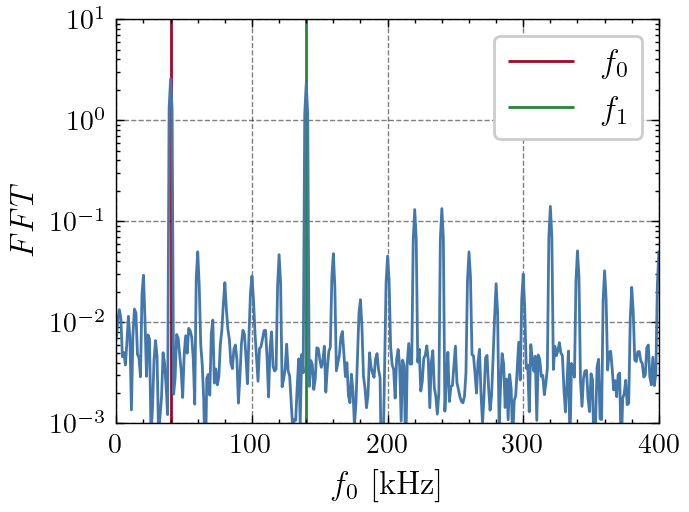

In [9]:
ymin    = 1e-3
ymax    = 1e1
arr     = df_min['Current'].values[start:]
arr     = arr - np.mean(arr)
xf, yf  = nanonets_utils.fft(arr, dt=1e-9)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xf/1e3, yf)
ax.vlines(f0/1e3,ymin,ymax,colors=nanonets_utils.red_color, label='$f_0$', zorder=0)
ax.vlines(f1/1e3,ymin,ymax,colors=nanonets_utils.green_color, label='$f_1$', zorder=0)
ax.set_xlim(0,400)
ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_ylabel("$FFT$", size='large')
ax.set_xlabel("$f_0$ [kHz]", size='large')
ax.legend(fontsize='large')

fig.savefig("../plots/frequency/fft_minimum_distorition.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/frequency/fft_minimum_distorition.pdf", transparent=False, bbox_inches='tight')

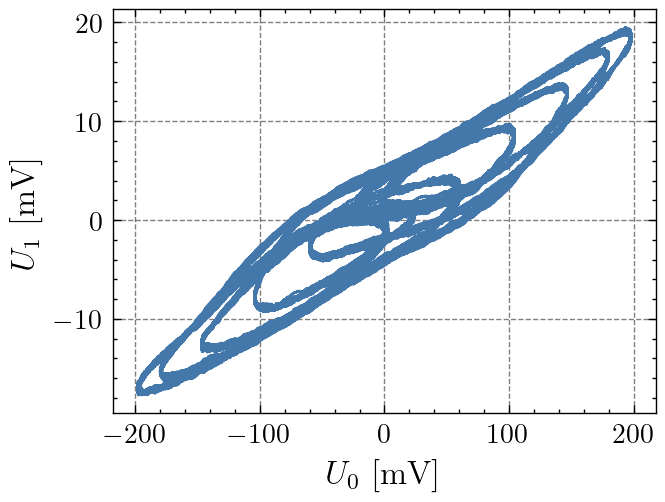

In [10]:
start   = 500000
xarr    = df_min['E0'].values[start:]*1000
arr     = df_min['Current'].values[start:]*1000

dx          = np.gradient(xarr)
dy          = np.gradient(arr)
magnitude   = np.sqrt(dx**2 + dy**2)
dx          /= magnitude
dy          /= magnitude

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xarr, arr)
# ax.quiver(xarr, arr, dx, dy, angles='xy',  scale_units='xy', scale=1, alpha=0.7)
ax.set_ylabel("$U_1$ [mV]", size='large')
ax.set_xlabel("$U_0$ [mV]", size='large')

fig.savefig("../plots/frequency/phase_minimum_distorition.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/frequency/phase_minimum_distorition.pdf", transparent=False, bbox_inches='tight')

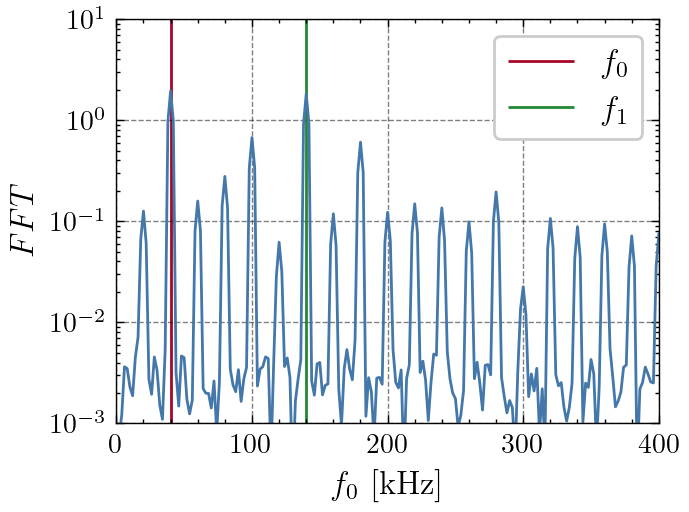

In [11]:
ymin    = 1e-3
ymax    = 1e1
arr     = df_max['Current'].values[start:]
arr     = arr - np.mean(arr)
xf, yf  = nanonets_utils.fft(arr, dt=1e-9)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xf/1e3, yf)
ax.vlines(f0/1e3,ymin,ymax,colors=nanonets_utils.red_color, label='$f_0$', zorder=0)
ax.vlines(f1/1e3,ymin,ymax,colors=nanonets_utils.green_color, label='$f_1$', zorder=0)
ax.set_xlim(0,400)
ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_ylabel("$FFT$", size='large')
ax.set_xlabel("$f_0$ [kHz]", size='large')
ax.legend(fontsize='large')

fig.savefig("../plots/frequency/fft_maximum_distorition.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/frequency/fft_maximum_distorition.pdf", transparent=False, bbox_inches='tight')

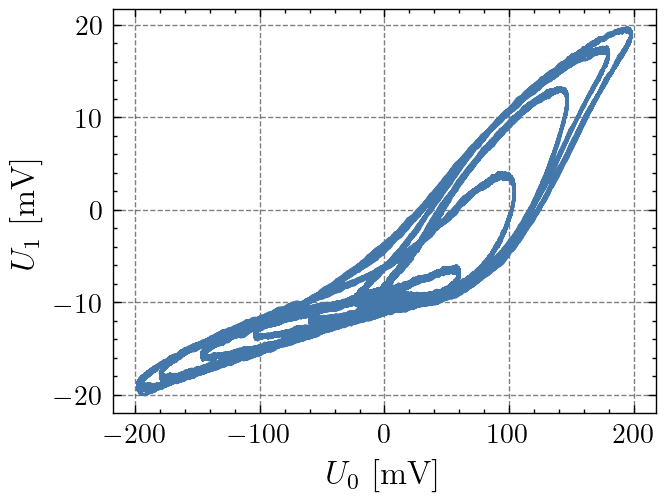

In [12]:
xarr    = df_max['E0'].values[start:]*1000
arr     = df_max['Current'].values[start:]*1000

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xarr, arr)
ax.set_ylabel("$U_1$ [mV]", size='large')
ax.set_xlabel("$U_0$ [mV]", size='large')

fig.savefig("../plots/frequency/phase_maximum_distorition.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/frequency/phase_maximum_distorition.pdf", transparent=False, bbox_inches='tight')

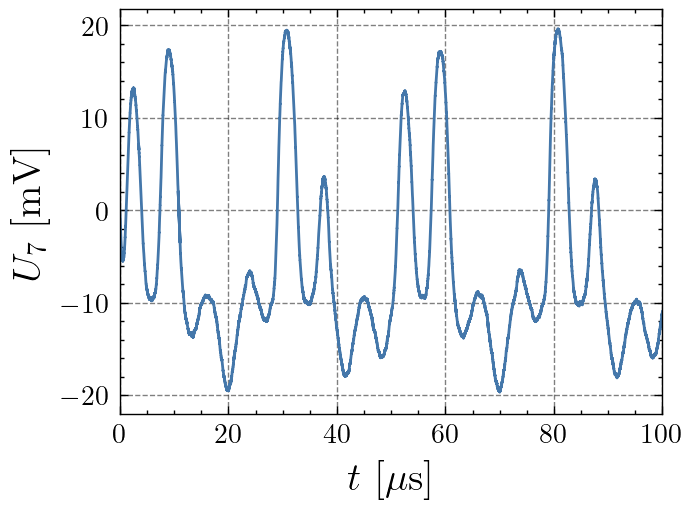

In [19]:
fig = plt.figure(dpi=200)
# fig.set_figheight(fig.get_figheight()*0.8)
ax  = fig.add_subplot()
ax.plot(time_steps[:-1]*1e6, df_max['Current']*1000)
ax.set_xlabel("$t$ [$\mu$s]", size='x-large')
ax.set_ylabel("$U_7$ [mV]", size='x-large')
ax.set_xlim(0,100)
fig.savefig("../plots/frequency/two_tone_output.svg", transparent=True, bbox_inches='tight')

(0.0, 100000.0)

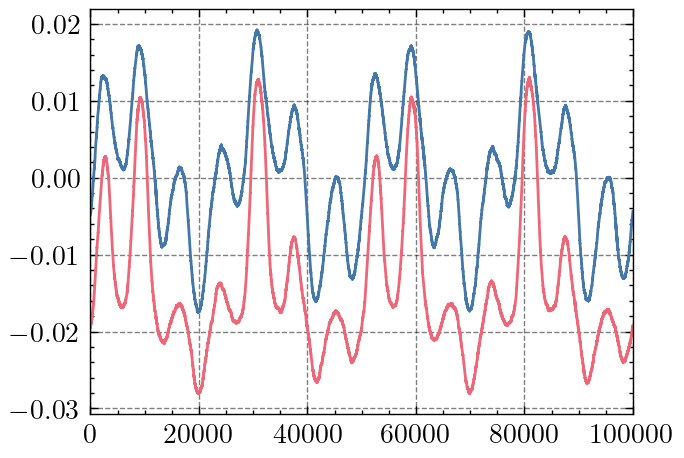

In [40]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(df_min['Current'].values[start:])
ax.plot(df_max['Current'].values[start:])
ax.set_xlim(0,100000)

## String

In [63]:
time_step       = 1e-10
radius          = 1e6
# radius          = 10.0
eq_step         = 0
N_min, N_max    = 2, 12
N_vals          = np.arange(N_min, N_max)
path            = '/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/freq/'
# path            = '/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/system_size/'
data_string     = {f : pd.read_csv(f"{path}Nx=11_Ny=1_Nz=1_Ne=2_{f}.csv").loc[eq_step:,:].reset_index(drop=True) for f in f_vals}
# states_string   = {f : pd.read_csv(f"{path}mean_state_Nx={N}_Ny=1_Nz=1_Ne=2_{f}.csv").loc[eq_step:,:].reset_index(drop=True) for f in f_vals}
t_vals          = np.arange(len(data_string[f_vals[0]]))*time_step*1e6

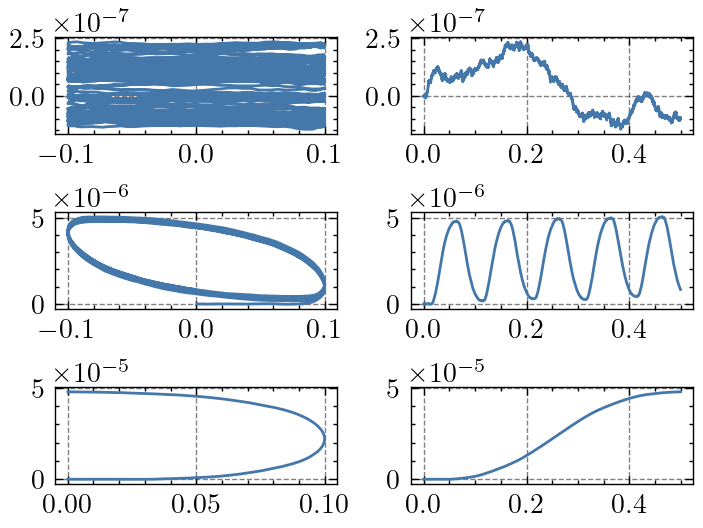

In [73]:
fig = plt.figure(dpi=200, layout='constrained')

for i, f in enumerate(f_vals):

    ax  = fig.add_subplot(3,2,2*i+1)
    ax.plot(volts[i][1:],data_string[f]['Current'])

    ax  = fig.add_subplot(3,2,2*i+2)
    ax.plot(t_vals,data_string[f]['Current'])

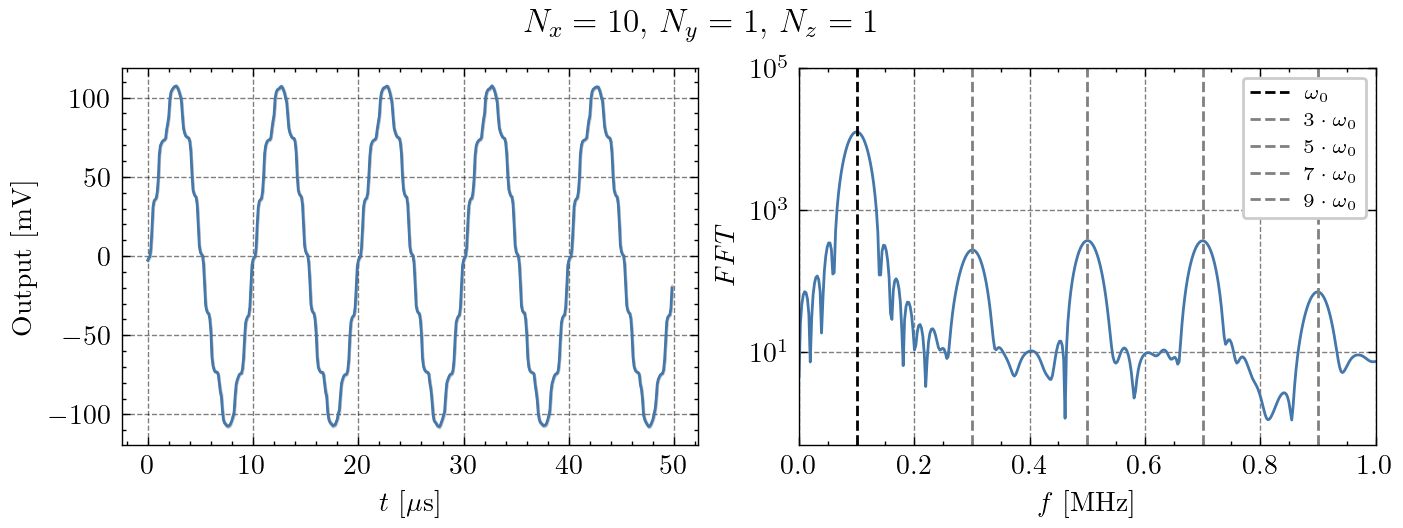

In [50]:
N_p     = 10
y_min   = 0.5
y_max   = 100000
f1      = 0.1
vals    = data_string[N_p]['Current'].values*1000
vals_e  = data_string[N_p]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, vals)
ax.fill_between(t_vals, vals-vals_e, vals+vals_e, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]')
# ax.set_xlim(0,80)

ax      = fig.add_subplot(1,2,2)
signal  = vals.copy()
signal  = signal - np.mean(signal)
xf, f   = nanonets_utils.fft(signal=signal, dt=time_step, n_padded=4096)

ax.plot(xf/1e6 ,f)
ax.vlines(f1, y_min, y_max, colors='black', ls='--', label='$\omega_0$')
ax.vlines(3*f1, y_min, y_max, colors='grey', ls='--', label='$3 \cdot \omega_0$')
ax.vlines(5*f1, y_min, y_max, colors='grey', ls='--', label='$5 \cdot \omega_0$')
ax.vlines(7*f1, y_min, y_max, colors='grey', ls='--', label='$7 \cdot \omega_0$')
ax.vlines(9*f1, y_min, y_max, colors='grey', ls='--', label='$9 \cdot \omega_0$')
ax.set_xlim(0,1)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_yscale('log')
ax.legend(ncol=1, frameon=True, fontsize='x-small', framealpha=1, loc='upper right')
fig.suptitle(f'$N_x = {N_p}$, $N_y = 1$, $N_z = 1$')
fig.savefig(f"../plots/radius_{radius}/{N_p}_string_output_fft.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/radius_{radius}/{N_p}_string_output_fft.pdf", bbox_inches='tight', transparent=False)

In [51]:
f0              = 1e5
harmonics       = []

for key, df in data_string.items():

    signal          = df['Current'].values*1000
    arr_strength    = nanonets_utils.harmonic_strength(signal=signal, f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

thd_string  = np.sqrt(np.sum(np.array(harmonics)**2, axis=1))

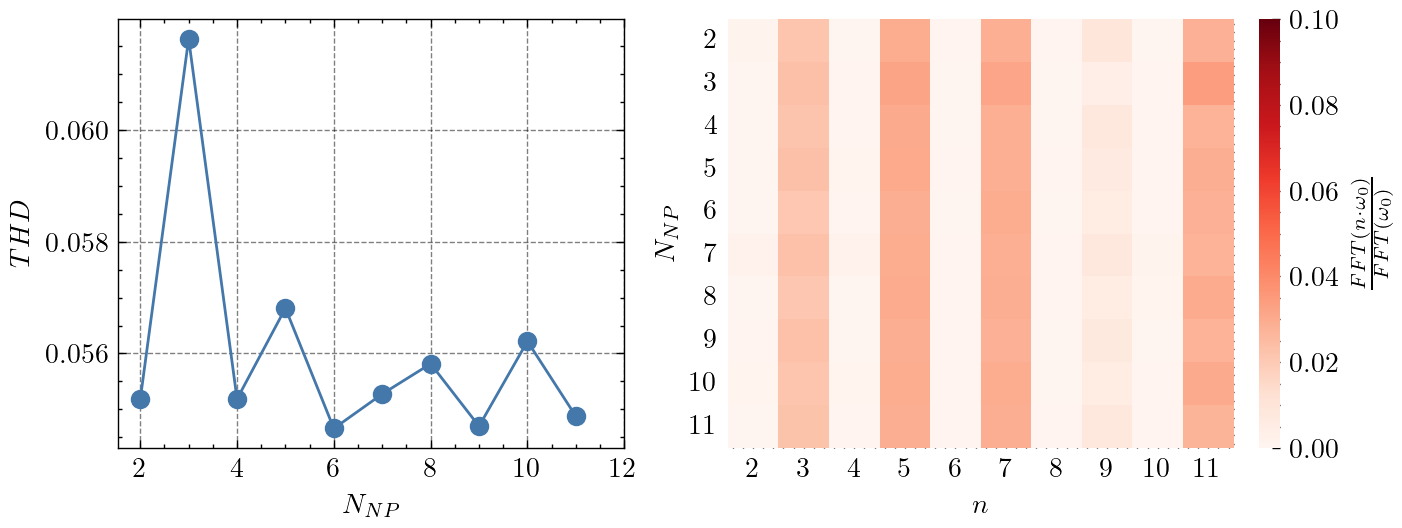

In [52]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot(1,2,1)
ax.plot(N_vals, thd_string, 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.arange(N_min,N_max+1,2))
ax.set_ylabel("$THD$")

df  = pd.DataFrame(harmonics, index=N_vals, columns=np.arange(2, len(arr_strength)+2))
ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$"},
                  vmin=0, vmax=0.1)

ax.set_ylabel("$N_{NP}$")
ax.set_xlabel("$n$")
plt.yticks(rotation=0)

fig.savefig(f"../plots/radius_{radius}/THD_string_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/radius_{radius}/THD_string_sample.pdf", bbox_inches='tight', transparent=False)

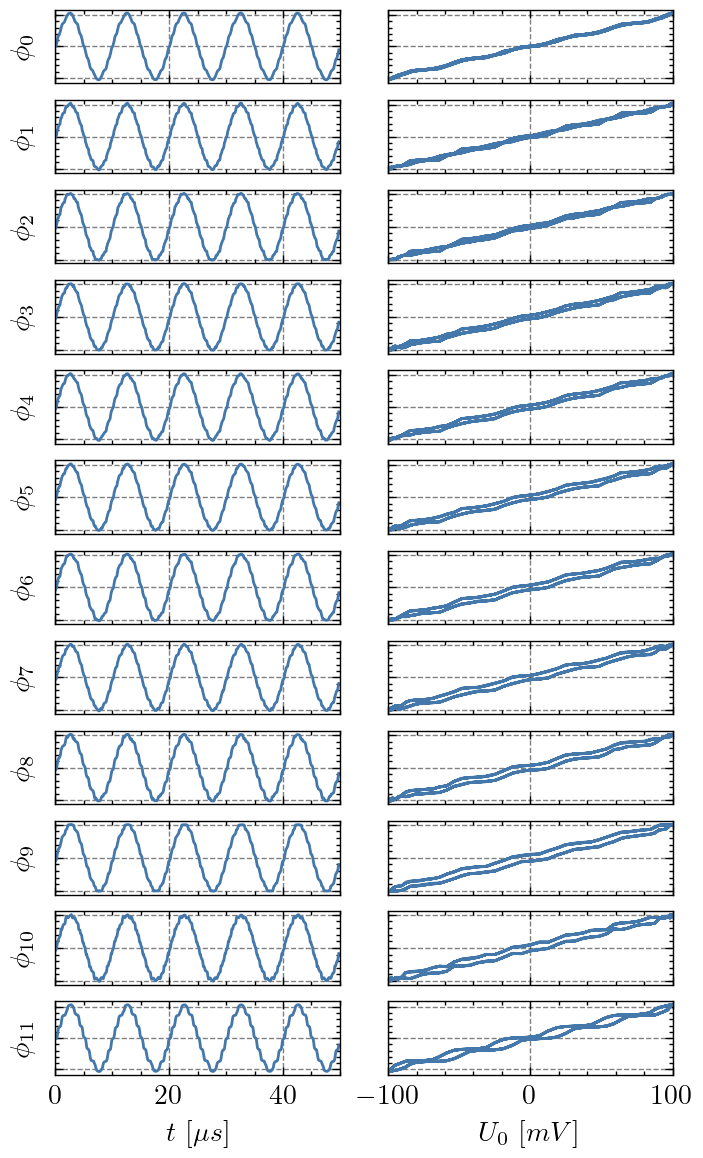

In [56]:
N_val   = 11
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*2*N_val/10)

for i in range(N_val+1):

    ax  = fig.add_subplot(N_val+1,2,2*i+1)
    arr = states_string[N_val][f"{i}"]
    ax.plot(t_vals, arr)

    ax.set_ylabel("$\phi_{"+f"{i}"+"}$")
    ax.set_xlim(0,50)
    ax.set_yticklabels("")
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [$\mu s$]")

    ax  = fig.add_subplot(N_val+1,2,2*i+2)
    ax.plot(x_vals, arr)
    ax.set_yticklabels("")
    ax.set_xlim(-100,100)
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$U_0$ [$mV$]")
    fig.savefig(f"../plots/radius_{radius}/{N_val}_string_np_responses.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"../plots/radius_{radius}/{N_val}_string_np_responses.pdf", bbox_inches='tight', transparent=False)

## Network

In [61]:
# radius          = 10.0
radius          = 1000000.0
data_network    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}
states_network  = {N : 1000*pd.read_csv(f"{path}mean_state_Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}

In [62]:
f0              = 1e5
harmonics       = []

for key, df in data_network.items():

    signal          = df['Current'].values*1000
    arr_strength    = nanonets_utils.harmonic_strength(signal=signal, f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

thd_network  = np.sqrt(np.sum(np.array(harmonics)**2, axis=1))

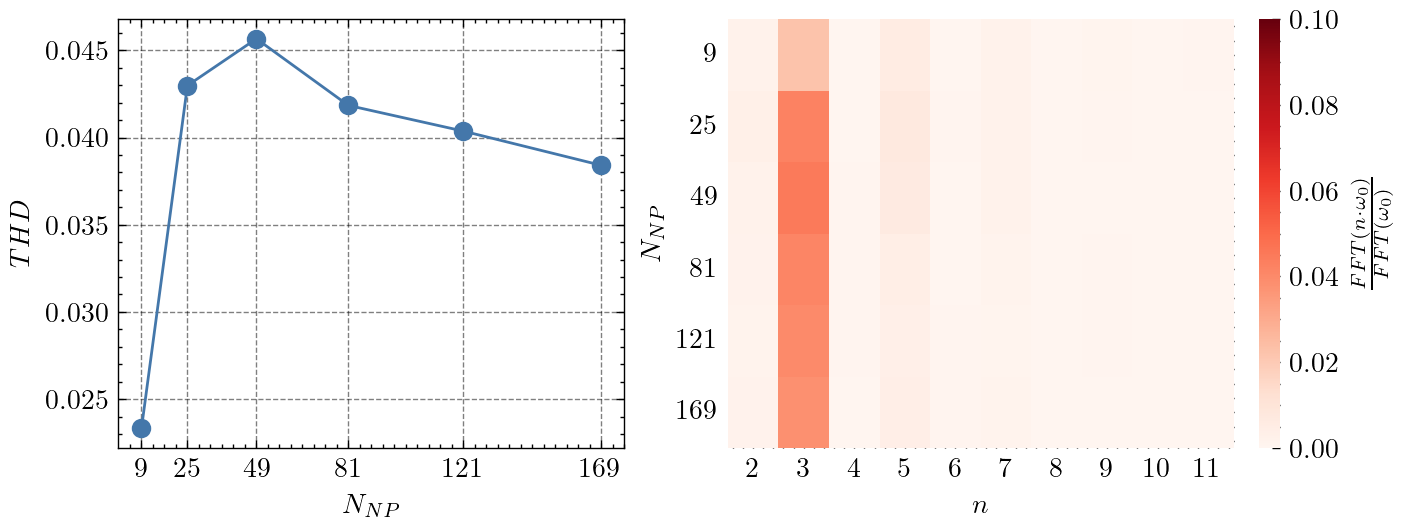

In [65]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot(1,2,1)
ax.plot(np.array([3,5,7,9,11,13])**2, thd_network, 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.array([3,5,7,9,11,13])**2)
ax.set_ylabel("$THD$")

df  = pd.DataFrame(harmonics, index=np.array([3,5,7,9,11,13])**2, columns=np.arange(2, len(arr_strength)+2))
ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$"},
                  vmin=0, vmax=0.1)

ax.set_ylabel("$N_{NP}$")
ax.set_xlabel("$n$")
plt.yticks(rotation=0)

fig.savefig(f"../plots/radius_{radius}/THD_network_sample.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/radius_{radius}/THD_network_sample.pdf", bbox_inches='tight', transparent=False)

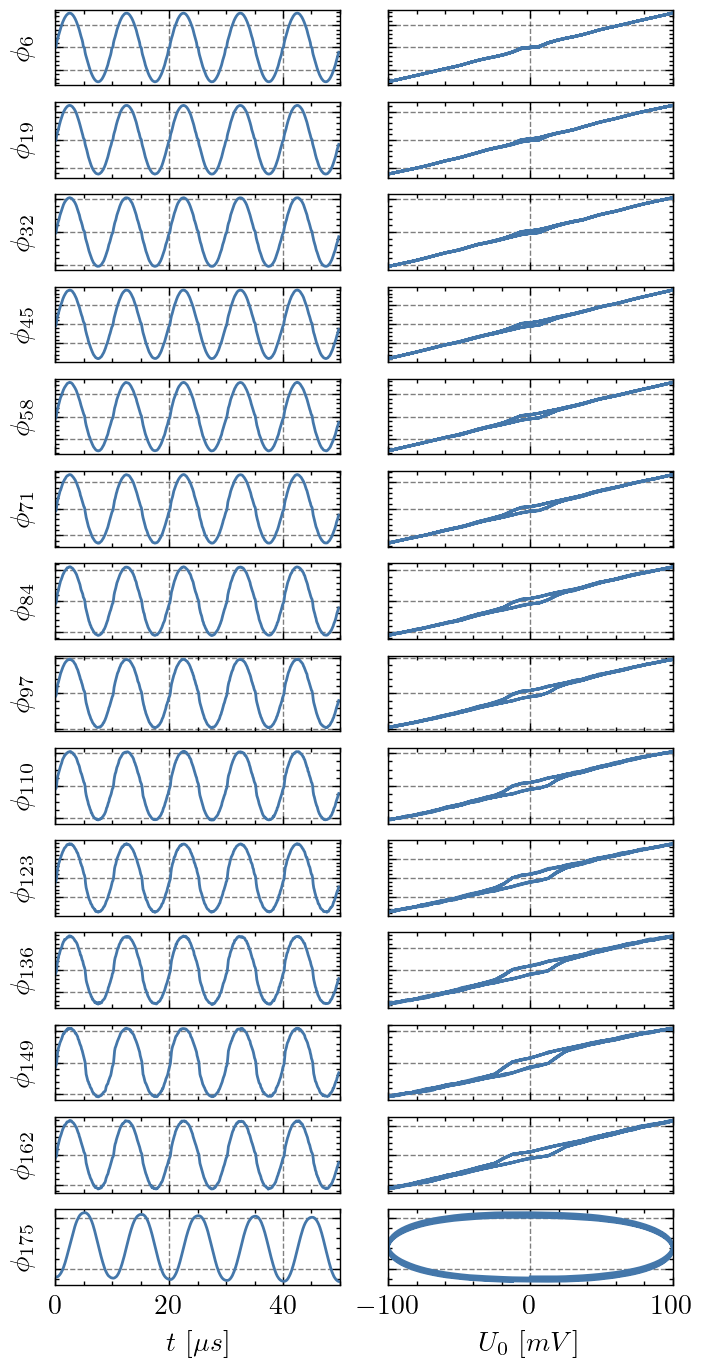

In [66]:
N_val   = 13
idx     = N_val//2
phi     = [states_network[N_val][f"{idx+i*N_val}"].values for i in range(N_val)]
phi.append(states_network[N_val][f"{N_val**2}"].values)

fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*2*N_val/10)

for i, arr in enumerate(phi):

    ax  = fig.add_subplot(N_val+1,2,2*i+1)
    ax.plot(t_vals, arr)

    ax.set_ylabel("$\phi_{"+f"{idx+i*N_val}"+"}$")
    ax.set_xlim(0,50)
    ax.set_yticklabels("")
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [$\mu s$]")

    ax  = fig.add_subplot(N_val+1,2,2*i+2)
    ax.plot(x_vals, arr)
    ax.set_yticklabels("")
    ax.set_xlim(-100,100)
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$U_0$ [$mV$]")
        
    fig.savefig(f"../plots/radius_{radius}/{N_val}_network_np_responses.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"../plots/radius_{radius}/{N_val}_network_np_responses.pdf", bbox_inches='tight', transparent=False)

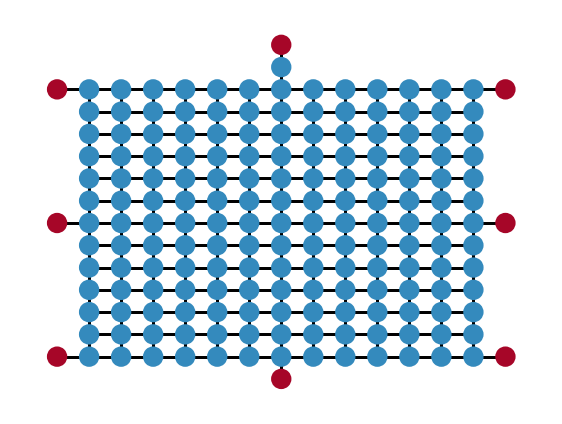

In [346]:
from system_size import return_network_topology

t_arr       = return_network_topology(N_val)
sim_class   = nanonets.simulation(t_arr)
fig, ax     = plt.subplots(dpi=200)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=40)
fig.savefig(f"../plots/{N_val}_{N_val}_network.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/{N_val}_{N_val}_network.pdf", bbox_inches='tight', transparent=False)

---